## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

100%|██████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:03<00:00, 2770998.43it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 23719540.60it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2342124.70it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 53362825.68it/s]


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



Text(0.5, 1.0, 'Image label: 8')

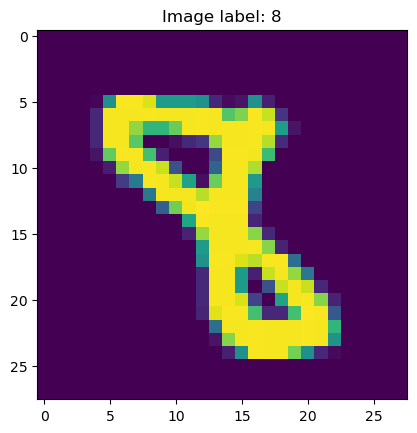

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [3]:
loss_func = nn.CrossEntropyLoss()

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
# Creating model instance
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10)
)

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

Локальные тесты для проверки вашей модели доступны ниже:

In [6]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [7]:
import time

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #X_batch = X_batch.reshape(-1, 784)
            y_pred = model(X_batch)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in test_data_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                #X_batch = X_batch.reshape(-1, 784)

                # compute predictions
                y_pred = model(X_batch)
                ep_val_loss.append(loss_func(y_pred, y_batch).item())
                y_pred = y_pred.argmax(dim=1)
                ep_val_accuracy.append((y_pred == y_batch).float().mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [11]:
n_epochs = 5

train_loss, val_loss, val_accuracy = train_model(model, train_data_loader, test_data_loader, loss_func, opt, n_epochs)

Epoch 1 of 5 took 14.426s
	  training loss: 0.303290
	validation loss: 0.285541
	validation accuracy: 0.921
Epoch 2 of 5 took 11.548s
	  training loss: 0.283130
	validation loss: 0.274949
	validation accuracy: 0.924
Epoch 3 of 5 took 11.766s
	  training loss: 0.272543
	validation loss: 0.271826
	validation accuracy: 0.924
Epoch 4 of 5 took 12.062s
	  training loss: 0.266431
	validation loss: 0.265229
	validation accuracy: 0.927
Epoch 5 of 5 took 11.775s
	  training loss: 0.262131
	validation loss: 0.265134
	validation accuracy: 0.925


In [12]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

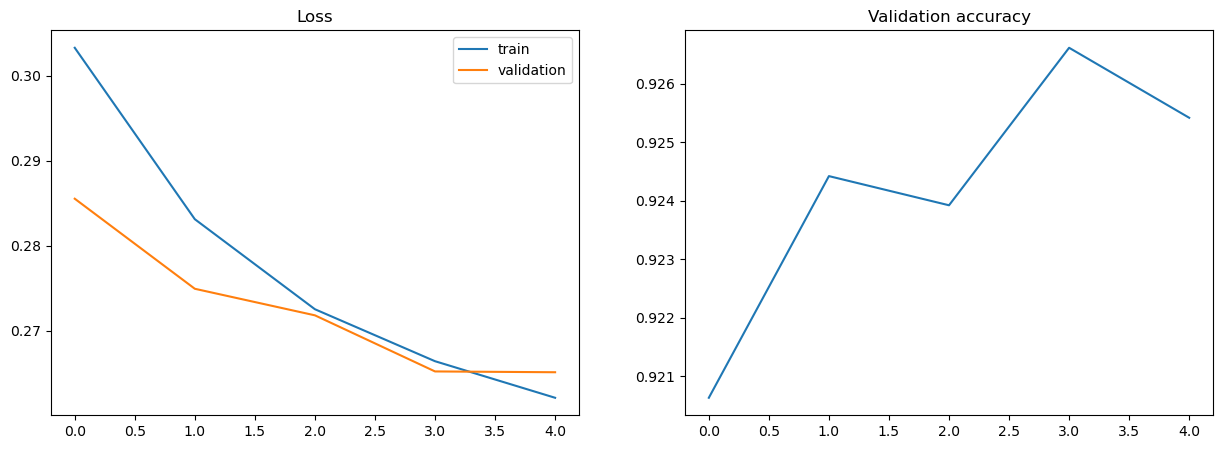

In [13]:
plot_train_process(train_loss, val_loss, val_accuracy)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [14]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [15]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.93123


In [16]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [17]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9254


Проверка, что необходимые пороги пройдены:

In [18]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [19]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
# # do not change the code in the block below
# # __________start of block__________
# import os

# assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

# def get_predictions(model, eval_data, step=10):

#     predicted_labels = []
#     model.eval()
#     with torch.no_grad():
#         for idx in range(0, len(eval_data), step):
#             y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
#             predicted_labels.append(y_predicted.argmax(dim=1))

#     predicted_labels = torch.cat(predicted_labels)
#     return predicted_labels

# loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

# submission_dict = {
#     'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
#     'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
# }

# np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
# print('File saved to `submission_dict_hw07.npy`')
# # __________end of block__________

File saved to `submission_dict_hw07.npy`


In [21]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_hw07.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_hw07.json`')

File saved to `submission_dict_hw07.json`


На этом задание завершено. Поздравляем!